#Multihead Attention

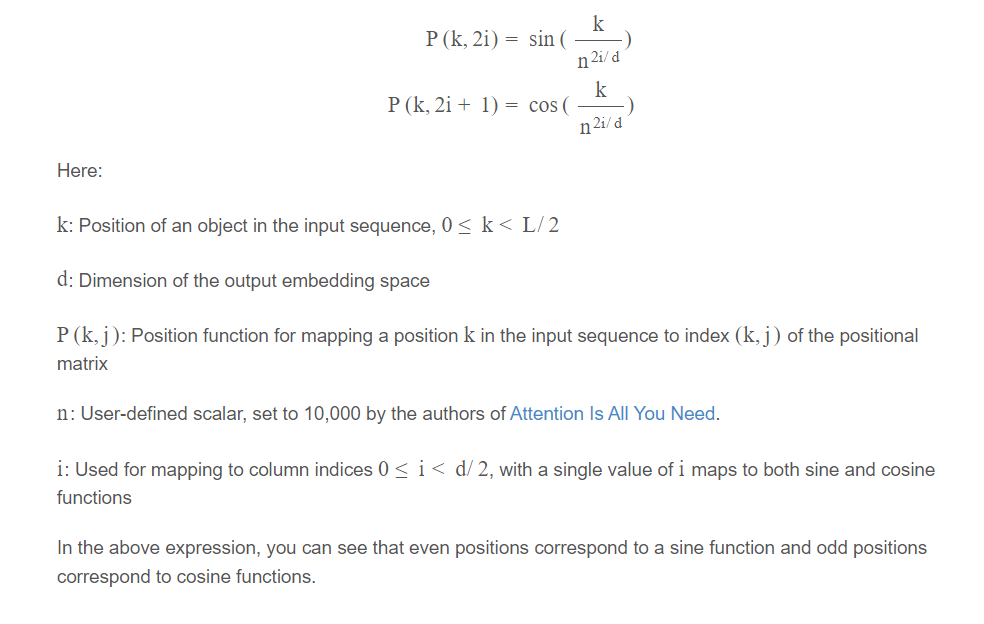

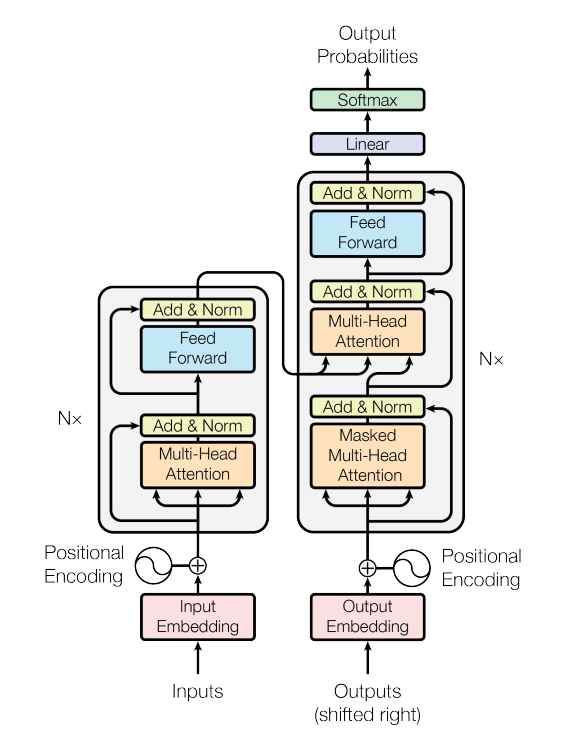

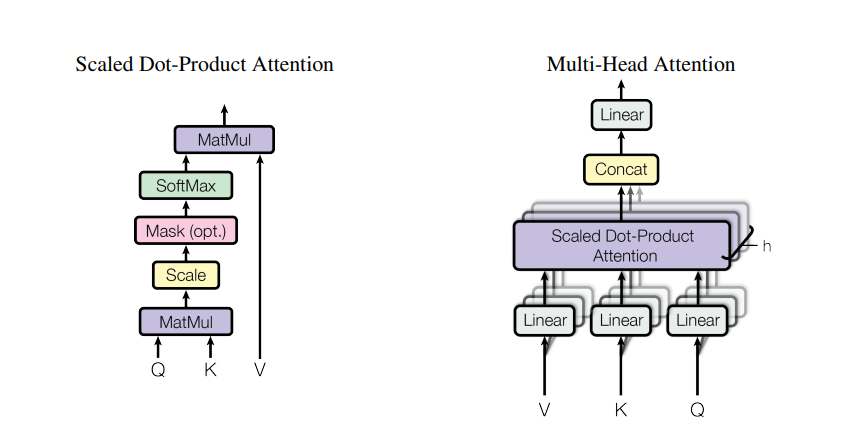

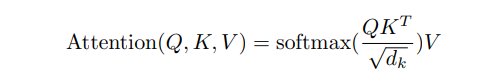

In [1]:
import torch
from torch import nn
import torch.nn.functional as F


In [6]:
import math
def scaled_product(q , k , v  , mask = None):
  dk = q.size()[-1]
  pre_scaled = torch.matmul( q , k.transpose(-1 , -2))
  scaled = pre_scaled / math.sqrt(dk)
  if mask is not None:
    scaled += mask
  print("checked")
  attention_coeff = F.softmax(scaled , dim = -1)
  attention_matrix = torch.matmul(attention_coeff , v)
  return attention_matrix , attention_coeff

In [7]:
class PositionalEncoding(nn.Module):
  def __init__(self , d_model , max_sequence_length):
    super().__init__()
    self.max_sequence_length = max_sequence_length
    self.d_model = d_model

  def forward(self):
    even_i = torch.arange(0, self.d_model, 2).float()
    denominator = torch.pow(10000, even_i/self.d_model)
    position = (torch.arange(self.max_sequence_length)
                      .reshape(self.max_sequence_length, 1))
    even_PE = torch.sin(position / denominator)
    odd_PE = torch.cos(position / denominator)
    stacked = torch.stack([even_PE, odd_PE], dim=2)
    PE = torch.flatten(stacked, start_dim=1, end_dim=2)
    return PE

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out

In [9]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out

In [10]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [11]:
class Encoder_layer(nn.Module):
  def __init__(self , d_model , ffn_layer , num_heads , drop_prob):
    super(Encoder_layer , self).__init__()
    self.attention = MultiHeadAttention(d_model , num_heads)
    self.normlayer1 = LayerNormalization([d_model])
    self.dropout1 = nn.Dropout(p =  drop_prob)
    self.ffn = PositionwiseFeedForward(d_model , ffn_layer , drop_prob)
    self.norm2 = LayerNormalization(parameters_shape=[d_model])
    self.dropout2 = nn.Dropout(p=drop_prob)

  def forward(self, x):
    residual_x = x
    print("------- ATTENTION 1 ------")
    x = self.attention(x, mask=None)
    print("------- DROPOUT 1 ------")
    x = self.dropout1(x)
    print("------- ADD AND LAYER NORMALIZATION 1 ------")
    x = self.normlayer1(x + residual_x)
    residual_x = x
    print("------- ATTENTION 2 ------")
    x = self.ffn(x)
    print("------- DROPOUT 2 ------")
    x = self.dropout2(x)
    print("------- ADD AND LAYER NORMALIZATION 2 ------")
    x = self.norm2(x + residual_x)
    return x

In [12]:
class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

In [13]:
class Encoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialEncoder(*[Encoder_layer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask, start_token, end_token):
        x = self.sentence_embedding(x, start_token, end_token)
        x = self.layers(x, self_attention_mask)
        return x

In [15]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size()
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y

In [17]:
class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

class Decoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask, start_token, end_token):
        y = self.sentence_embedding(y, start_token, end_token)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y

In [20]:
class Transformer(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                french_vocab_size,
                english_to_index,
                french_to_index,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN
                ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, english_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, french_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.linear = nn.Linear(d_model, french_vocab_size)

    def forward(self,
                x,
                y,
                encoder_self_attention_mask=None,
                decoder_self_attention_mask=None,
                decoder_cross_attention_mask=None,
                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False,
                dec_end_token=False):
      x = self.encoder(x, encoder_self_attention_mask, start_token=enc_start_token, end_token=enc_end_token)
      out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask, start_token=dec_start_token, end_token=dec_end_token)
      out = self.linear(out)
      return out



In [21]:
class SentenceEmbedding(nn.Module):

  def __init__(self , max_sequence_length , d_model , language_to_index , START_TOKEN , END_TOKEN , PADDING_TOKEN):
    super().__init__()
    self.vocab_size = len(language_to_index)
    self.max_sequence_length = max_sequence_length
    self.embedding = nn.Embedding(self.vocab_size , d_model)
    self.language_to_index = language_to_index
    self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
    self.dropout = nn.Dropout(p=0.1)
    self.START_TOKEN = START_TOKEN
    self.END_TOKEN = END_TOKEN
    self.PADDING_TOKEN = PADDING_TOKEN

  def batch_tokenize(self , batch , start_token , end_token):

    def tokenize(sentence , start_token , end_token):
      index = [self.language_to_index[token] for token in list(sentence)]

      if(start_token):
        index.insert(0 , self.language_to_index[self.START_TOKEN])

      if end_token:
        index.append(self.language_to_index[self.END_TOKEN])

        for _ in range(len(index), self.max_sequence_length):
                index.append(self.language_to_index[self.PADDING_TOKEN])
        return torch.tensor(index)

    tokenized = []
    for sentence_num in range(len(batch)):
        tokenized.append( tokenize(batch[sentence_num], start_token, end_token) )
    tokenized = torch.stack(tokenized)
    return tokenized



  def forward(self , x , start_token , end_token):
    x = self.batch_tokenize(x , start_token , end_token)
    x = self.embedding(x)
    pos = self.position_encoder(x)
    x = self.dropout(x + pos)
    return x


